# <center>Test Notebook for changes in the SFR models in 21cmFirstCLASS</center>
### <center>By S. Libanore and T. Kadosh</center>

This notebook is used to check and debug the changes we made on the .py and .c files of 21cmFirstCLASS in order to introduce and study different SFR models. <br>
All changes in the .py and .c files can be tracked using the string '# !!! SLTK:'.

First of all, we import all the needed modules and we set the configuration for the plotting style.

In [44]:
# Import the packages required for this tutorial

import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt

import py21cmfast as p21c # To run 21cmFirstCLASS (21cmFAST)
from py21cmfast import plotting # For plotting global signals, coeval boxes, lightcone boxes and power spectra
import py21cmfast.power_spectrum as ps # Calculate power spectrum from the lightcone
from py21cmfast.inputs import global_params # Useful in this tutorial to plot the initial conditions for the simulation

import pickle
from copy import copy
from scipy.interpolate import interp1d

import astropy.units as u

In [2]:
plt.rcParams.update({"text.usetex": True, "font.family": "Times new roman"}) # Use latex fonts
colors =  ['#377eb8', '#ff7f00', '#4daf4a',
           '#f781bf', '#a65628', '#984ea3',
           '#999999', '#e41a1c', '#dede00']

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors) # Set the color palette as default

color_test = '#eb884d'

Here we import the quantities that were originally run and stored from the official 21cmFirstCLASS release.<br>
These quantities are used as benchmark in our studies, to check that all the changes that we made keep the code consistent.

In particular, we stored and now import:
- the global brightness temperature
- the global spin temperature
- the global kinetic temperature
- the Ly alpha flux
- the ionization factor
- the 21cm power spectrum
- the halo mass function
- the UV luminosity function

In [3]:
# Load the benchmark global quantities
with open('./benchmark_SFR/benchmark_globals.pkl', 'rb') as file:
    benchmark_globals_dict = pickle.load(file)

In [4]:
# Load the benchmark power spectrum
with open('./benchmark_SFR/benchmark_pk.pkl', 'rb') as file:
    benchmark_pk = pickle.load(file)

In [5]:
# Load the benchmark hmf
with open('./benchmark_SFR/benchmark_dndMh.pkl', 'rb') as file:
   benchmark_dndMh = pickle.load(file)

In [6]:
# Load the benchmark luminosity function
with open('./benchmark_SFR/benchmark_dndMag.pkl', 'rb') as file:
   benchmark_dndMag = pickle.load(file)

## Set up parameters for the new simulation

In this example notebook, we estimate the 21cm signal from recombination to reionization. <br>
We assume &Lambda;CDM cosmological parameters from Planck 2018.

In each run, the astrophysics is set in order to test the current level of code development.

In [7]:
# Parameters related with the size of the simulation itself and with the kind of outputs required -- ALWAYS THE SAME
user_params = {"BOX_LEN": 100, # size of the simulated box (in comoving Mpc) 
               "HII_DIM": 25, # number of cells along each axis of the coeval box - Note: more cells means longer runtime! 
               "N_THREADS": 6, # the amount of processors the code uses in parallelization
               } 

# Cosmological parameters in LCDM -- ALWAYS THE SAME
cosmo_params = {"hlittle": 0.6736, # hubble parameter
                "OMb": 0.0493, # baryon density
                "OMm": 0.3153, # matter (CDM+baryon) density
                "A_s": 2.1e-9, # amplitude of the primordial fluctuations
                "POWER_INDEX": 0.9649, # spectral index of the primordial spectrum
                "tau_reio": 0.0544, # optical depth to reionization
                }

# Parameters that set the physical processes the code accounts for -- ALWAYS THE SAME
flag_options = {"USE_MINI_HALOS": False, } # if False, popIII stars are not included - Note: if set to True, the runtime increases significantly!


The benchmark model was run using astrophysical parameters:
```python
astro_params = {"F_STAR10": -1.25, 
                "ALPHA_STAR": 0.5,
                "F_ESC10": -1.35,
                "ALPHA_ESC": -0.3, 
                "L_X": 40.5, 
                "sigma_Muv":0.45 
               }
```


In [8]:
# Astrophysical parameters 
astro_params = {"SFR_MODEL": "MUN21", # !!! SLTK: our new input !!! 
                "F_STAR10": -1.25, # star formation efficiency (atomic cooling galaxies) for pivot mass 1e10 Msun (log10)
                "ALPHA_STAR": 0.5, # slope of the dependency of star formation efficiency on the host halo mass 
                "F_ESC10": -1.35, # escape fraction of Lyman photons into the IGM for pivot mass 1e10 Msun (log10)
                "ALPHA_ESC": -0.3, # slope of the dependency of escape fraction on the host halo mass 
                "L_X": 40.5, # X-ray luminosity (log10)
                "sigma_Muv":0.45 # the dispersion in the halo mass - UV magnitude relation
                }

### Set up the required outputs

As in 21cmFAST, 21cmFirstCLASS allows you to extract the quantities evolved in the simulation using different formats.<br>
In this notebook, to save memory, we only rely on the aforementioned global quantities to compare with our benchmark model. We also include the lightcone quantities required to compute the power spectrum afterwards.

In [9]:
global_quantities = ("brightness_temp", # brightness temperature
                     "Tk_box", # kinetic temperature
                     "Ts_box", # spin temperature
                     "xH_box", # neutral hydrogen fraction
                     "J_Lya_box" # Lyman alpha flux - new feature in 21cmFirstCLASS! 
                     )

coeval_quantities = []

input_coeval_redshifts = []

lightcone_quantities = ("brightness_temp",)

## Run the simulation

To run 21cmFirstCLASS we use the build-in 'run_lightcone' of 21cmFAST.<br>
Everything in 21cmFirstCLASS can then be accessed from the resulting lightcone object. <br>
We consider both dark ages and cosmic dawn, even if the astrophysical parameters only affect the latter, to be sure that the modifications that we implement do not affect the overall structure of the code.

In [10]:
lightcone = p21c.run_lightcone(redshift = 6., # minimum redshift at which the simulation will stop
                               random_seed = 1, # numerical seed -- if None, each run will produce different initial conditions, with the same cosmological power spectrum but different spatial realization. You need to specify the random seed to coherently compare two different runs, due to cosmic variance. 
                               regenerate = True, # create new data even if cached are found
                               write = False, # whether or no to save cached files
                               user_params = user_params,
                               astro_params = astro_params, 
                               flag_options = flag_options,
                               cosmo_params = cosmo_params,
                               global_quantities = global_quantities,
                               save_coeval_quantities = coeval_quantities,
                               save_coeval_redshifts = input_coeval_redshifts,
                               lightcone_quantities = lightcone_quantities) ; 

Now running CLASS...
---------------------------------------
SL: imported standard CLASS
---------------------------------------
Now generating initial boxes...


21cmFAST (cosmic dawn): 100%|██████████| 84/84 [00:38<00:00,  2.16redshift/s]


Now evaluating tau to reionization and re-running CLASS...


The following cell was initially used to store the benchmark global quantities.<br>
De-comment it only if you want to overwrite that file.

In [11]:
#benchmark_globals_dict = {
#'bench_z': lightcone.node_redshifts,
#'bench_Tb':lightcone.global_quantities["brightness_temp"],
#'bench_Tk':lightcone.global_quantities["Tk_box"],
#'bench_Ts':lightcone.global_quantities["Ts_box"],
#'bench_xH':lightcone.global_quantities["xH_box"],
#'bench_JLa':lightcone.global_quantities["J_Lya_box"]
#}
#
## Save the dictionary to a file
#with open('./benchmark_SFR/benchmark_globals.pkl', 'wb') as file:
#    pickle.dump(benchmark_globals_dict, file)

### Estimate the halo mass function and luminosity function

In [12]:
redshift_test_dnd = np.array((6.,8.,10.))

In [13]:
hmf_lightcone = p21c.compute_HMF(
    # we plot and compare the hmf for some example redshifts
    redshifts = redshift_test_dnd,
    user_params = user_params,
    cosmo_params = cosmo_params,
    astro_params = astro_params,
    flag_options = flag_options,
    nbins = 100,
    )

In [14]:
luminosity_function_lightcone = p21c.compute_luminosity_function(
    # we plot and compare the luminosity function for some example redshifts
    redshifts = redshift_test_dnd,
    user_params = user_params,
    cosmo_params = cosmo_params,
    astro_params = astro_params,
    flag_options = flag_options,
    nbins = 100,
    )

The following cells were initially used to store the benchmark halo and luminosity functions.<br>
De-comment it only if you want to overwrite those files.

#### Important: 
The random seed is different in each laptop! If you are running this file for the first time, you HAVE TO run the fiducial model again! 

In [15]:
#benchmark_dndMag = copy(hmf_lightcone)
#with open('./benchmark_SFR/benchmark_dndMh.pkl', 'wb') as file:
#    pickle.dump(hmf_lightcone, file)

In [16]:
#benchmark_dndMag = copy(luminosity_function_lightcone)
#with open('./benchmark_SFR/benchmark_dndMag.pkl', 'wb') as file:
#    pickle.dump(luminosity_function_lightcone, file)

### Estimate the power spectrum 

In [17]:
# compute the power spectrum from the lightcone box in equally spaced chunks
power_spectrum_lightcone = ps.lightcone_power_spectrum(lightcone,
                                                       nchunks = 15) ;

The following cell was initially used to store the benchmark power spectrum.<br>
De-comment it only if you want to overwrite that file.
#### Important: 
The random seed is different in each laptop! If you are running this file for the first time, you HAVE TO run the fiducial model again! 

In [18]:
#benchmark_pk = copy(power_spectrum_lightcone)
#with open('./benchmark_SFR/benchmark_pk.pkl', 'wb') as file:
#    pickle.dump(benchmark_pk, file)

## Plot the lightcone outputs

Plotting in 21cmFirstCLASS is easy! All the automatic plotting functions are defined in the module
```python
plotting.py
```  

### Global quantities

#### Evolution of the kinetic and spin temperatures over the full redshift range.

This is the only case in which we show the dark ages; if these are coeherent, we expect the following to also agree at the level of the dark ages.

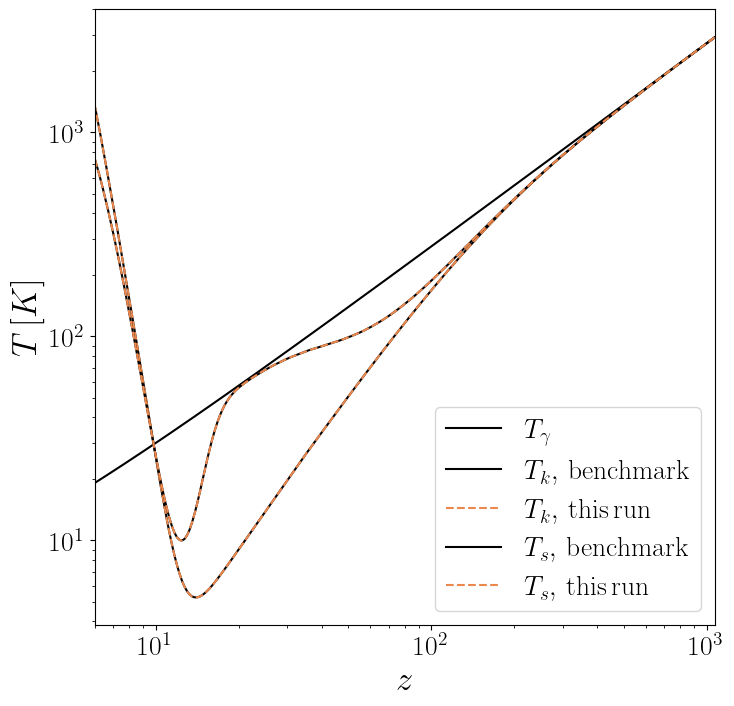

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# plot the CMB temperature, which evolves as (1+z)
ax.plot(lightcone.node_redshifts,2.728*(1.+np.array(lightcone.node_redshifts)),label=r'$T_{\gamma}$',color='k')

# plot the kinetic temperature
ax.plot(benchmark_globals_dict['bench_z'],benchmark_globals_dict['bench_Tk'],label=r'$T_k,\,{\rm benchmark}$', color='k', linestyle='-')
fig, ax = plotting.plot_global_history(lightcone,kind='Tk_box',label=r'$T_k,\,{\rm this\,run}$',ax=ax, color=color_test, linestyle='--')

# plot the spin temperature
ax.plot(benchmark_globals_dict['bench_z'],benchmark_globals_dict['bench_Ts'],label=r'$T_s,\,{\rm benchmark}$', color='k', linestyle='-')
fig, ax = plotting.plot_global_history(lightcone,kind='Ts_box',label=r'$T_s,\,{\rm this\,run}$',ax=ax, color=color_test, linestyle='--')

# change the y-axis label
ax.set_ylabel(r'$T\, [K]$',fontsize=25) ; 

In [20]:
different_Tk = max(abs((lightcone.global_quantities['Tk_box']-benchmark_globals_dict['bench_Tk'])/benchmark_globals_dict['bench_Tk'] * 100))
if round(different_Tk,1) > 0.:
    z_different_Tk = benchmark_globals_dict['bench_z'][np.where((abs((lightcone.global_quantities['Tk_box']-benchmark_globals_dict['bench_Tk'])/benchmark_globals_dict['bench_Tk'] * 100)) == different_Tk)[0][0]]

    print('Wrt the benchmark model, Tk in the new model differs max ' + str(round(different_Tk,1)) + '%; this is reached at z = ' + str(round(z_different_Tk,1)))
else:
    print('\nThe new model has no differences in Tk\n')

different_Ts = max(abs((lightcone.global_quantities['Ts_box']-benchmark_globals_dict['bench_Ts'])/benchmark_globals_dict['bench_Ts'] * 100))
if round(different_Ts,1) > 0.:
    z_different_Ts = benchmark_globals_dict['bench_z'][np.where((abs((lightcone.global_quantities['Ts_box']-benchmark_globals_dict['bench_Ts'])/benchmark_globals_dict['bench_Ts'] * 100)) == different_Ts)[0][0]]

    print('Wrt the benchmark model, Ts in the new model differs max ' + str(round(different_Ts,1)) + '%; this is reached at z = ' + str(round(z_different_Ts,1)))
else:
    print('The new model has no differences in Ts\n')


The new model has no differences in Tk

The new model has no differences in Ts



#### Evolution of the brightness temperature during cosmic dawn.

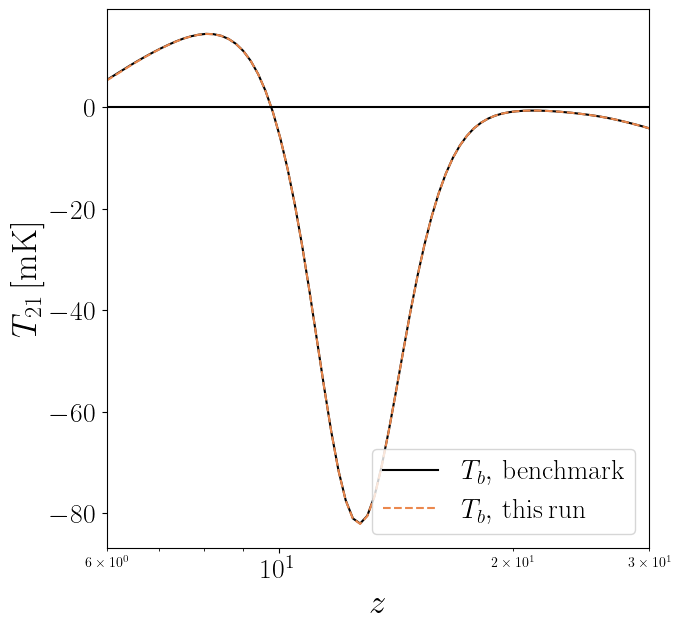

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(7,7)) # set the plot size

ax.plot(benchmark_globals_dict['bench_z'],benchmark_globals_dict['bench_Tb'],label=r'$T_b,\,{\rm benchmark}$', color='k', linestyle='-')            
 
fig, ax = plotting.plot_global_history(lightcone,
                                       # you can specify the following properties for your plot; if None (or omitted) defaults are used
                                       kind = 'brightness_temp', # which quantity to plot, choose between the one listed in global_quantities
                                       x_kind='redshift', # this argument specifies plotted on the x-axis; can be set to 'redshift', 'frequency', or 'distance'
                                       xlabel = None,
                                       ylabel = None,
                                       xlog = None,
                                       ylog = None,
                                       # Note that this function accepts all the arguments of 'matplotlib.pyplot.plot'!
                                       color = color_test,
                                       ls='--',
                                       ax = ax,
                                       label=r'$T_b,\,{\rm this\,run}$'
                                       ) 
plt.xlim(6,30)
plt.legend(fontsize=20,loc=4)
# Add a black horizontal dashed line at zero 
ax.plot([lightcone.node_redshifts[0],lightcone.node_redshifts[-1]],[0,0],color='k',ls='-') ; 

#plt.xlim(6,10)
#plt.ylim(5,18)

In [22]:
different_Tb = max(abs((lightcone.global_quantities['brightness_temp']-benchmark_globals_dict['bench_Tb'])/benchmark_globals_dict['bench_Tb'] * 100))
if round(different_Tb,1) > 0.:
    z_different_Tb = benchmark_globals_dict['bench_z'][np.where((abs((lightcone.global_quantities['brightness_temp']-benchmark_globals_dict['bench_Tb'])/benchmark_globals_dict['bench_Tb'] * 100)) == different_Tb)[0][0]]

    print('\nWrt the benchmark model, Tb in the new model differs max ' + str(round(different_Tb,1)) + '%; this is reached at z = ' + str(round(z_different_Tb,1)))
else:
    print('\nThe new model has no differences in Tb\n')


Wrt the benchmark model, Tb in the new model differs max 1.7%; this is reached at z = 6.0


#### Evolution of the ionization fraction during cosmic dawn.

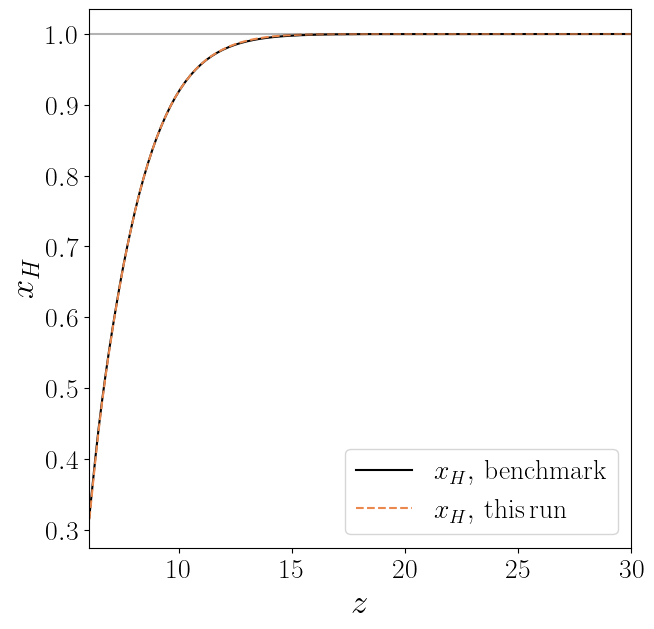

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(7,7)) # set the plot size

ax.plot(benchmark_globals_dict['bench_z'],benchmark_globals_dict['bench_xH'],label=r'$x_H,\,{\rm benchmark}$', color='k', linestyle='-')
fig, ax = plotting.plot_global_history(lightcone,
                                       # you can specify the following properties for your plot; if None (or omitted) defaults are used
                                       kind = 'xH', # which quantity to plot, choose between the one listed in global_quantities
                                       x_kind='redshift', # this argument specifies plotted on the x-axis; can be set to 'redshift', 'frequency', or 'distance'
                                       xlabel = None,
                                       ylabel = r'$x_H$',
                                       xlog = False,
                                       ylog = False,
                                       # Note that this function accepts all the arguments of 'matplotlib.pyplot.plot'!
                                       color = color_test,
                                       ls='--',
                                       ax = ax,
                                       label=r'$x_H,\,{\rm this\,run}$'
                                       ) 

plt.xlim(6,30)
plt.legend(fontsize=20,loc=4)
# Add a black horizontal dashed line at zero 
ax.plot([lightcone.node_redshifts[0],lightcone.node_redshifts[-1]],[1,1],color='k',ls='-',alpha=0.3) ; 

#plt.xlim(6,10)
#plt.ylim(0.3,0.5)

In [24]:
different_ionization = max(abs((lightcone.global_quantities['xH_box']-benchmark_globals_dict['bench_xH'])/benchmark_globals_dict['bench_xH'] * 100))
if round(different_ionization,1) > 0.:
    z_different_ionization = benchmark_globals_dict['bench_z'][np.where((abs((lightcone.global_quantities['xH_box']-benchmark_globals_dict['bench_xH'])/benchmark_globals_dict['bench_xH'] * 100)) == different_ionization)[0][0]]

    print('\nWrt the benchmark model, the ionization in the new model differs max ' + str(round(different_ionization,1)) + '%; this is reached at z = ' + str(round(z_different_ionization,1)))
else:
    print('\nThe new model has no differences in xH\n')


Wrt the benchmark model, the ionization in the new model differs max 1.5%; this is reached at z = 6.0


#### Evolution of the Lyman alpha flux during cosmic dawn.

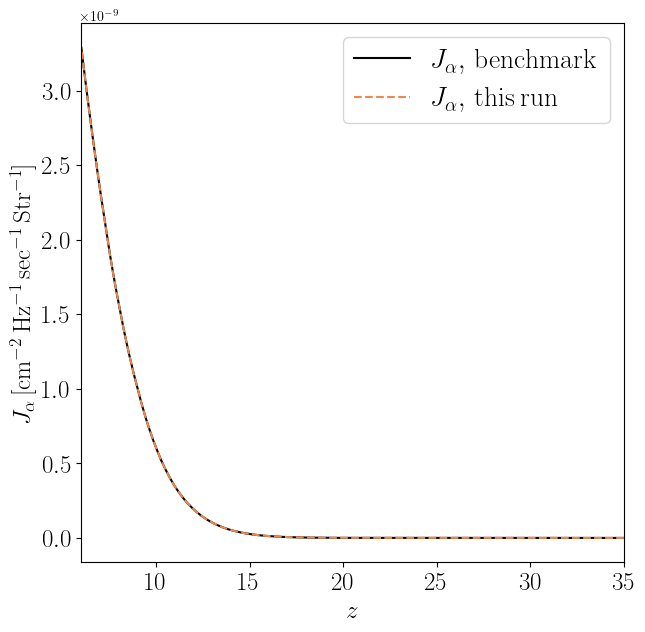

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(7,7)) # set the plot size

ax.plot(benchmark_globals_dict['bench_z'],benchmark_globals_dict['bench_JLa'],label=r'$J_\alpha,\,{\rm benchmark}$', color='k', linestyle='-')

fig, ax = plotting.plot_global_history(lightcone,
                                       kind='J_Lya_box',
                                       color=color_test,
                                       ls='--',
                                       label=r'$J_\alpha,\,{\rm this\,run}$',
                                       ax = ax)

# You can change the properties of the plot after it was created
ax.set_xlabel(xlabel=ax.get_xlabel(),fontsize=18)
ax.set_ylabel(ylabel=ax.get_ylabel(),fontsize=18)
ax.xaxis.set_tick_params(labelsize=18)
ax.yaxis.set_tick_params(labelsize=18)
ax.set_xlim([ax.get_xlim()[0],35])
ax.set_xscale('linear') ; 

In [26]:
different_JLa = max(abs((lightcone.global_quantities['J_Lya_box']-benchmark_globals_dict['bench_JLa'])/benchmark_globals_dict['bench_JLa'] * 100))
if round(different_JLa,1) > 0.:
    z_different_JLa = benchmark_globals_dict['bench_z'][np.where((abs((lightcone.global_quantities['J_Lya_box']-benchmark_globals_dict['bench_JLa'])/benchmark_globals_dict['bench_JLa'] * 100)) == different_JLa)[0][0]]

    print('Wrt the benchmark model, the Lya flux in the new model differs max ' + str(round(different_JLa,1)) + '%; this is reached at z = ' + str(round(z_different_JLa,1)))
else:
    print('\nThe new model has no differences in J_Lya\n')


The new model has no differences in J_Lya



/tmp/ipykernel_286066/3717205246.py:1: RuntimeWarning: invalid value encountered in divide
  different_JLa = max(abs((lightcone.global_quantities['J_Lya_box']-benchmark_globals_dict['bench_JLa'])/benchmark_globals_dict['bench_JLa'] * 100))


## Plot the power spectrum

Important Note:  The following power spectrum plots are imprecise, especially when we plot the power spectrum as a function of $k$, as we have set a small box with very low resolution! In order to achieve the correct power spectrum, you must increase BOX_LEN and HII_DIM!

#### Power spectrum at fixed k during cosmic dawn.

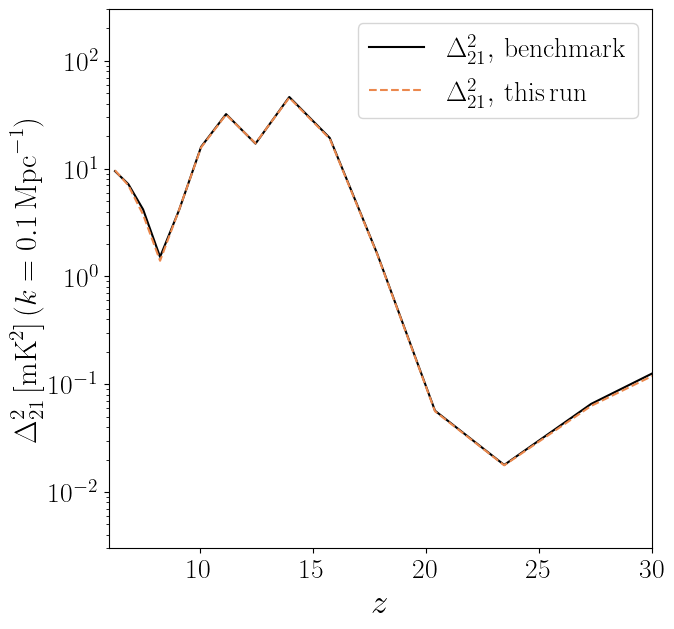

In [27]:
fig, ax1 = plt.subplots(1, 1, figsize=(7,7)) # set the plot size

kval = 0.1

plot_bench_pk = np.zeros(len(benchmark_pk.z_values))
for i in range(len(plot_bench_pk)):
    plot_bench_pk[i] = interp1d(benchmark_pk.k_values,benchmark_pk.ps_values[i],kind='cubic')(kval)

ax1.plot(benchmark_pk.z_values,plot_bench_pk,label=r'$\Delta_{21}^2,\,{\rm benchmark}$', color='k', linestyle='-')

fig, ax1 = plotting.plot_1d_power_spectrum(power_spectrum_lightcone,
                                           k=kval, # scale in units 1/Mpc
                                           smooth=False,
                                           ax = ax1,
                                           x_kind = 'redshift', # can be either 'redshift' or 'frequency'
                                           color=color_test,
                                           ls = '--',
                                           label=r'$\Delta_{21}^2,\,{\rm this\,run}$') # put redsfhit axis on top (applicable only if x_kind = 'frequency') 

ax1.set_xlim(6,30)
ax1.set_ylim(3e-3,3e2)
ax1.set_xscale('linear')

In [28]:
different_pk = np.max(abs((power_spectrum_lightcone.ps_values-benchmark_pk.ps_values)/benchmark_pk.ps_values * 100))
if round(different_pk,1) > 0.:
    z_different_pk = benchmark_pk.z_values[np.where((abs((power_spectrum_lightcone.ps_values-benchmark_pk.ps_values)/benchmark_pk.ps_values * 100)) == different_pk)[0][0]]
    k_different_pk = benchmark_pk.k_values[np.where((abs((power_spectrum_lightcone.ps_values-benchmark_pk.ps_values)/benchmark_pk.ps_values * 100)) == different_pk)[0][0]]
    
    print('\nWrt the benchmark model, the 21cm power spectrum in the new model differs max ' + str(round(different_pk,1)) + '%; this is reached at z = ' + str(round(z_different_pk,1)) + ', k = ' + str(round(k_different_pk,1)) ) 
else:
    print('\nThe new model has no differences in the power spectrum\n')


Wrt the benchmark model, the 21cm power spectrum in the new model differs max 11.4%; this is reached at z = 11.2, k = 0.9


#### Power spectrum as function of k, for fixed z during cosmic dawn.

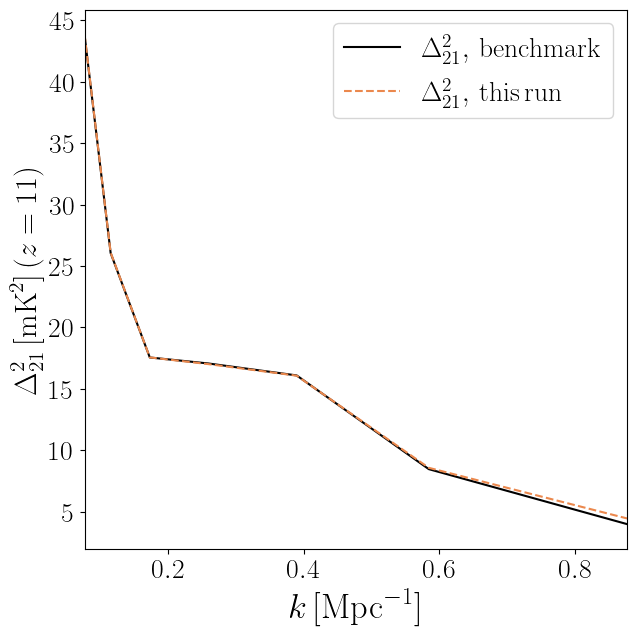

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(7,7)) # set the plot size

zval = 11

plot_bench_pk_z = np.zeros(len(benchmark_pk.k_values))
for i in range(len(plot_bench_pk_z)):
    plot_bench_pk_z[i] = interp1d(benchmark_pk.z_values,benchmark_pk.ps_values[:,i],kind='cubic')(zval)

ax.plot(benchmark_pk.k_values,plot_bench_pk_z,label=r'$\Delta_{21}^2,\,{\rm benchmark}$', color='k', linestyle='-')
fig, ax = plotting.plot_1d_power_spectrum(power_spectrum_lightcone,
                                          z=zval, # redshift, for best comparison we take the redshift of the coeval box
                                          smooth=False,
                                          color=color_test,
                                          ls='--',
                                          ax = ax,
                                          label=r'$\Delta_{21}^2,\,{\rm this\,run}$')


## Plot the halo mass function

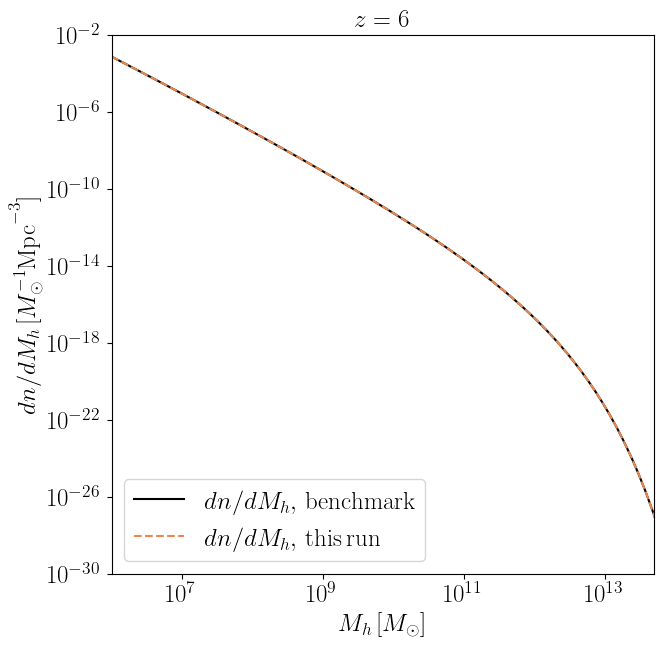

In [30]:
nplots = 1
for i in range(len(redshift_test_dnd[:nplots])):
    fig, ax = plt.subplots(1, 1, figsize=(7,7)) # set the plot size
    ax.loglog(benchmark_dndMh[0][i],benchmark_dndMh[1][i],label=r'$dn/dM_h,\,{\rm benchmark}$', color='k', linestyle='-')
    ax.loglog(hmf_lightcone[0][i],hmf_lightcone[1][i],label=r'$dn/dM_h,\,{\rm this\,run}$', color=color_test, linestyle='--')

    ax.xaxis.set_tick_params(labelsize=18)
    ax.yaxis.set_tick_params(labelsize=18)

    plt.xlabel(r'$M_h\,[M_\odot]$',fontsize=18)
    plt.ylabel(r'$dn/dM_h\,[{M_\odot^{-1}\rm Mpc}^{-3}]$',fontsize=18)
    plt.legend(fontsize=18,loc=3)
    plt.title(r'$z = %g$'%redshift_test_dnd[i], fontsize=18) 
    plt.ylim(1e-30,1e-2)
    plt.xlim(1e6,5e13);

## Plot the UV luminosity function

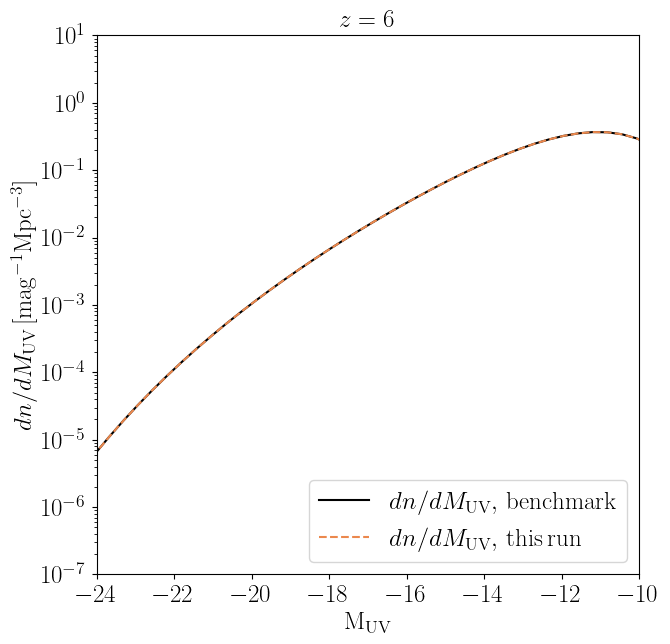

In [31]:
for i in range(len(redshift_test_dnd[:nplots])):
    fig, ax = plt.subplots(1, 1, figsize=(7,7)) # set the plot size
    ax.semilogy(benchmark_dndMag[0][i],benchmark_dndMag[2][i],label=r'$dn/dM_{\rm UV},\,{\rm benchmark}$', color='k', linestyle='-')
    ax.semilogy(luminosity_function_lightcone[0][i],luminosity_function_lightcone[2][i],label=r'$dn/dM_{\rm UV},\,{\rm this\, run}$', color=color_test, linestyle='--')

    ax.xaxis.set_tick_params(labelsize=18)
    ax.yaxis.set_tick_params(labelsize=18)

    plt.xlabel(r'$\rm M_{\rm UV}$',fontsize=18)
    plt.ylabel(r'$dn/dM_{\rm UV}\,[{\rm mag^{-1}Mpc^{-3}}]$',fontsize=18)
    plt.legend(fontsize=18,loc=4)
    plt.title(r'$z = %g$'%redshift_test_dnd[i],fontsize=18) 
    plt.xlim(-24,-10)
    plt.ylim(1e-7,10);

### Check the SFR model implemented in the code

Compare the SFR estimated from this notebook with the one that can be output from the code.<br>
Note that in this case (original model in 21cmFC) the SFR is defined as 
\begin{equation}
{\rm SFR} = f_*\frac{\Omega_b}{\Omega_m}M_h\,,\quad\quad f_* = f_{*,10}\left(\frac{M_h}{10^{10}M_\odot}\right)^{\alpha_*}
\end{equation}
while the $f_{\rm duty}$ factor is accounted in the computation of the luminosity function.

In [64]:
Mh_vals = np.logspace(6,16)
z_vals = np.linspace(5,35)

# MUN21
SF_eff = lambda Mh: pow(10,lightcone.astro_params.F_STAR10)*(Mh/1e10)**lightcone.astro_params.ALPHA_STAR
fstar  = lambda Mh: min(1,SF_eff(Mh) )

H0 = (67*u.km/u.Mpc/u.s).to(u.yr**-1)
Hubble = lambda z: H0.value*np.sqrt(lightcone.cosmo_params.OMm*(1+z)**3+lightcone.cosmo_params.OMl) 
test_SFR = lambda Mh,z: fstar(Mh) * lightcone.cosmo_params.OMb / lightcone.cosmo_params.OMm * Mh / lightcone.astro_params.t_STAR * Hubble(z)


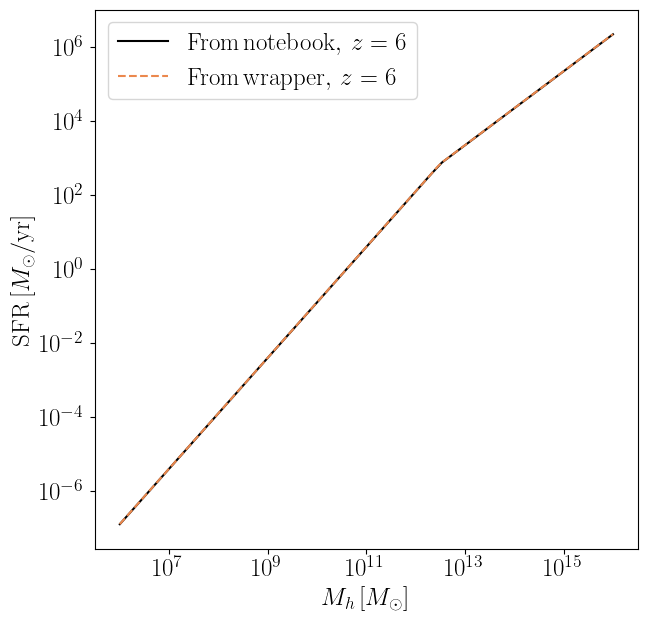

In [65]:
SFR = p21c.wrapper.compute_wSFR(Mh = hmf_lightcone[0], redshifts=redshift_test_dnd, user_params=user_params, cosmo_params=cosmo_params,flag_options=flag_options,astro_params=astro_params)

fig1, ax1 = plt.subplots(1, 1, figsize=(7,7)) # set the plot size
for i in range(len(redshift_test_dnd[:nplots])):
    ax1.loglog(Mh_vals,np.vectorize(test_SFR)(Mh_vals,redshift_test_dnd[i]),label=r'${\rm From\, notebook,\, }\,z=%g$'%redshift_test_dnd[i], color='k',linestyle='-')
    ax1.loglog(hmf_lightcone[0][i],SFR[i],label=r'${\rm From\, wrapper,\, }\,z=%g$'%redshift_test_dnd[i], color=color_test,linestyle='--')

ax1.set_xlabel(r'$M_h\,[M_\odot]$',fontsize=18)
ax1.set_ylabel(r'${\rm SFR}\,[M_\odot/{\rm yr}]$',fontsize=18)
ax1.legend(fontsize=18)
ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
